In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
i

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [25]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [18]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 145.18020610823692, HWHM 2.2272054061461866
Found peak in I at [MHz] 145.4938020756419, HWHM 1.8315013957755653
Found peak in Q at [MHz] 144.47690414796756, HWHM 2.3651610651016175


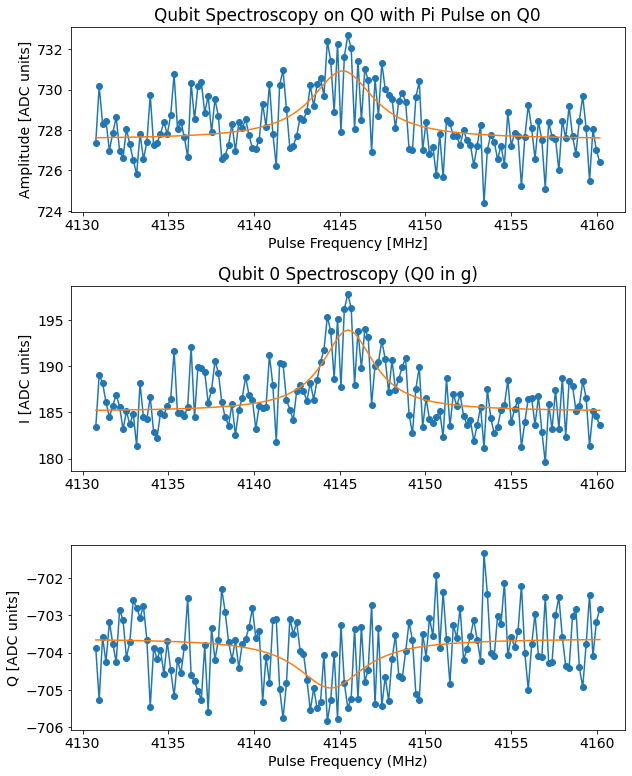

Fit Q0 frequency [MHz]: 145.4938020756419


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3464.2892848441684, HWHM 3.6204613815846542
Found peak in I at [MHz] 3464.3911596925545, HWHM 3.5375069958904333
Found peak in Q at [MHz] 3464.239893984642, HWHM 3.7037263922901724


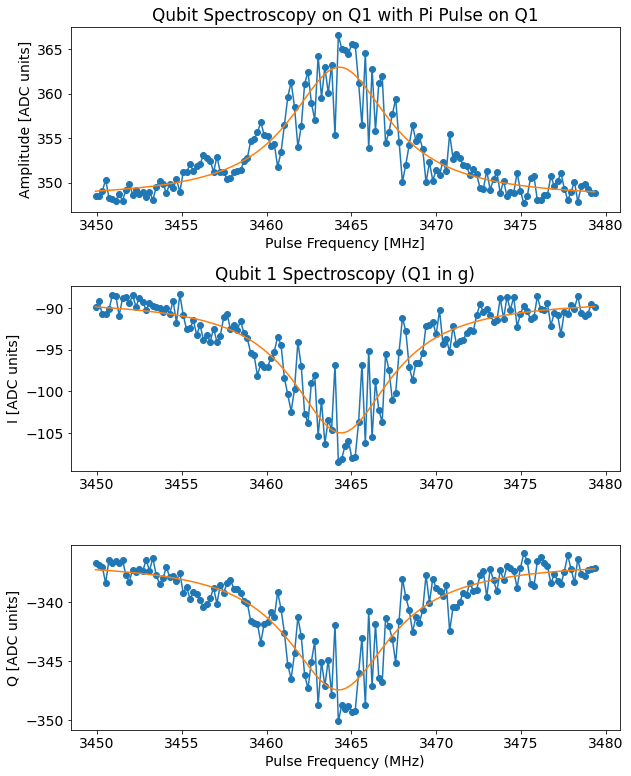

Fit Q1 frequency [MHz]: 3464.239893984642


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 807.6168067690717, HWHM 0.8563470856315668
Found peak in I at [MHz] 807.0561776269412, HWHM 2.094666771559652
Found peak in Q at [MHz] 807.648350423252, HWHM 0.7433769672528296


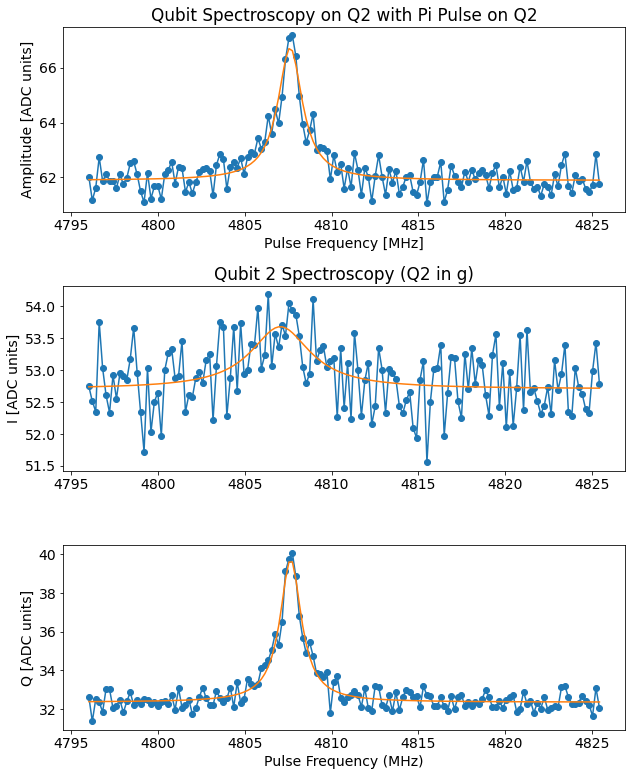

Fit Q2 frequency [MHz]: 807.648350423252


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 422.21483099382095, HWHM 5.496056911598673
Found peak in I at [MHz] 422.1080596728494, HWHM 5.903724295468633
Found peak in Q at [MHz] 422.67622365378764, HWHM 3.7455466635018198


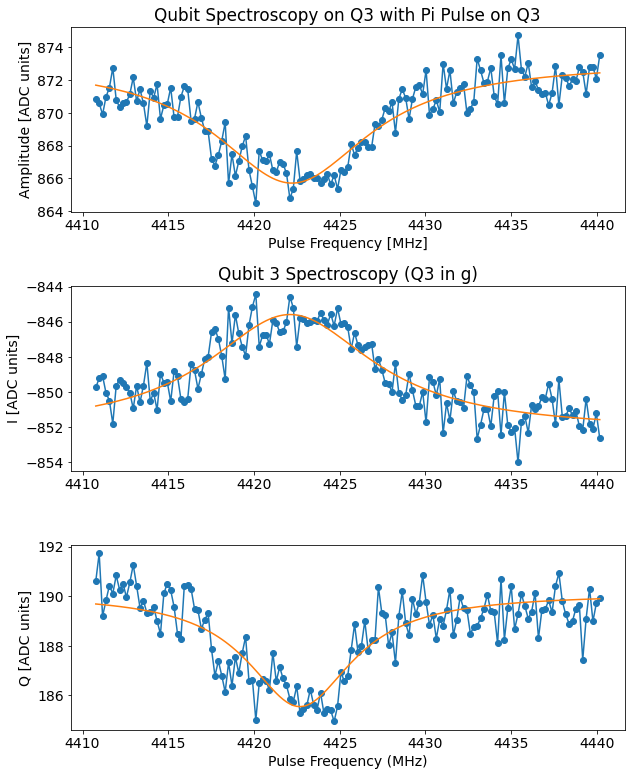

Fit Q3 frequency [MHz]: 422.21483099382095
Qubit freqs [145.4938020756419, 3464.239893984642, 807.648350423252, 422.21483099382095]


In [10]:
qfreqs = []
for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 30
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=300, # Number of averages per point
        rounds=10, # Number of start to finish sweeps to average over
        pulseB=False, # Whether to apply pi pulse to qubit B
        length=5, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        qubits=[qubit0, qubit0],
    )
    
    qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3459.9070075879836, HWHM 2.7255249543296047
Found peak in I at [MHz] 3459.6720258032587, HWHM 2.4343993722719897
Found peak in Q at [MHz] 3460.0260958521303, HWHM 2.8789893769460204


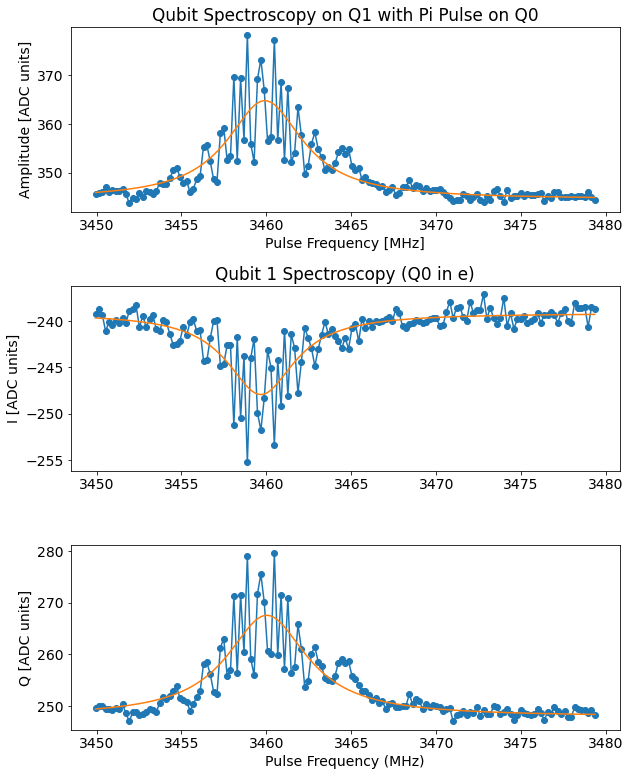

Fit Q1 frequency with ZZ shift [MHz]: 3459.6720258032587
Q1 shift due to Q0 in e [MHz]: -5.068359467808932


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3463.738750523217, HWHM 1.4645892310551814
Found peak in I at [MHz] 3463.699176167828, HWHM 1.3482021869938237
Found peak in Q at [MHz] 3463.7634214023183, HWHM 1.5235003230044697


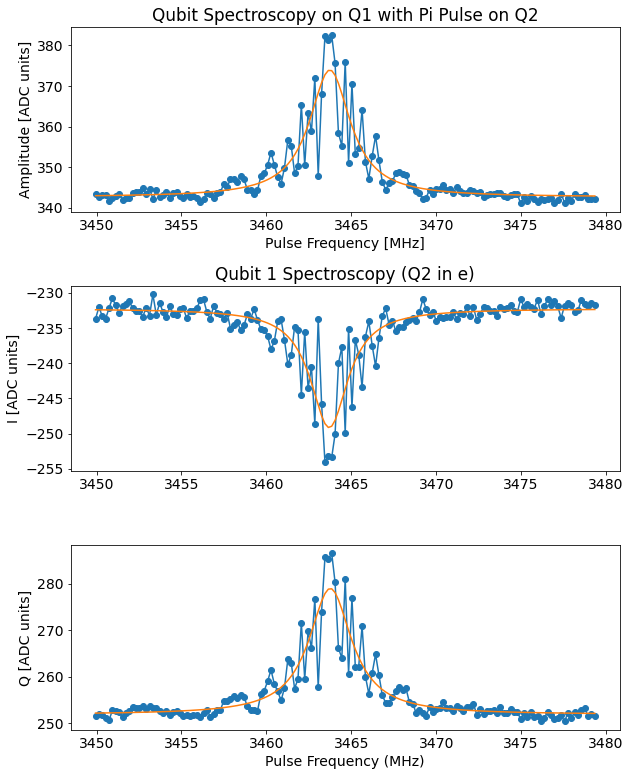

Fit Q1 frequency with ZZ shift [MHz]: 3463.7634214023183
Q1 shift due to Q2 in e [MHz]: -0.976963868749408


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3463.580661291441, HWHM 1.4485226232954675
Found peak in I at [MHz] 3463.5386011058454, HWHM 1.3709936414694401
Found peak in Q at [MHz] 3463.6008714727027, HWHM 1.4890791115716033


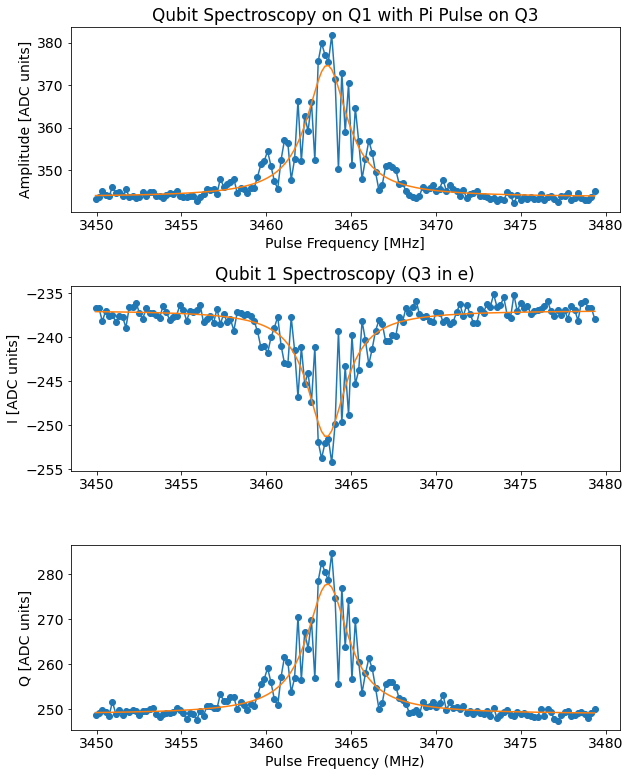

Fit Q1 frequency with ZZ shift [MHz]: 3463.5386011058454
Q1 shift due to Q3 in e [MHz]: -1.201784165222307
[[ 0.          0.          0.          0.        ]
 [-5.06835947  0.         -0.97696387 -1.20178417]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [19]:
for qubit0 in range(4): # qubit to measure
    for qubit1 in range(4): # qubit to pulse to e
        if qubit0 != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 30
        npts = 151
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=300, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=5, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # pulse gain for qubit we are measuring
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [20]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, 0.0, 0.0, 0.0, -5.068359467808932, 0.0, -0.976963868749408, -1.201784165222307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: {ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]}')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3459.11148271 3464.17984218 3463.20287831 3462.97805801]


# Get couplings by optimization

In [22]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [17]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [18]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [19]:
x0 = np.array([100, 100, 100, 10, 10, 10])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {1e3*result.x}')
gs_opt = result.x

qubit freqs [4145.57203495 3464.7274884  4810.82654194 4425.57      ]
alphas [-224.47579811 -100.4744884  -199.72821506 -149.80566031]
Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [50.39415367 19.61102264  1.          1.          1.          1.        ]


In [20]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -4.71267755 -0.10534621 -0.28344964]
 [-4.23607803  0.         -0.1686929  -0.27847814]
 [ 0.51462421 -0.12676679  0.         -0.06125637]
 [ 3.05564266  2.63569956  3.31273346  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.00000000e+00 -4.47366220e+00 -1.02275419e-02 -1.32812357e-02]
 [-4.47366220e+00  0.00000000e+00 -1.37550481e-01 -6.39672946e-04]
 [-1.02275419e-02 -1.37550481e-01  0.00000000e+00 -7.38593916e-03]
 [-1.32812357e-02 -6.39672946e-04 -7.38593916e-03  0.00000000e+00]]
Optimization error: 27.94403609061249


# ZZ shifted pi pulse calibrations for Q1

In [23]:
save_data = False
saved_files = []

In [24]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 0 #########
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3459.6610591571143
Fit frequency from I [MHz]: 1.9762409361840492 +/- 0.0010318697866932409
Suggested new pi pulse frequency from fit I [MHz]:
 	3459.68481822093
 	3455.68481822093
T2 Ramsey from fit I [us]: 10.267033251089513
Fit frequency from Q [MHz]: 1.9739317992591845 +/- 0.0016569378550376928
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3459.687127357855
 	3455.687127357855
T2 Ramsey from fit Q [us]: 10.815110840324355


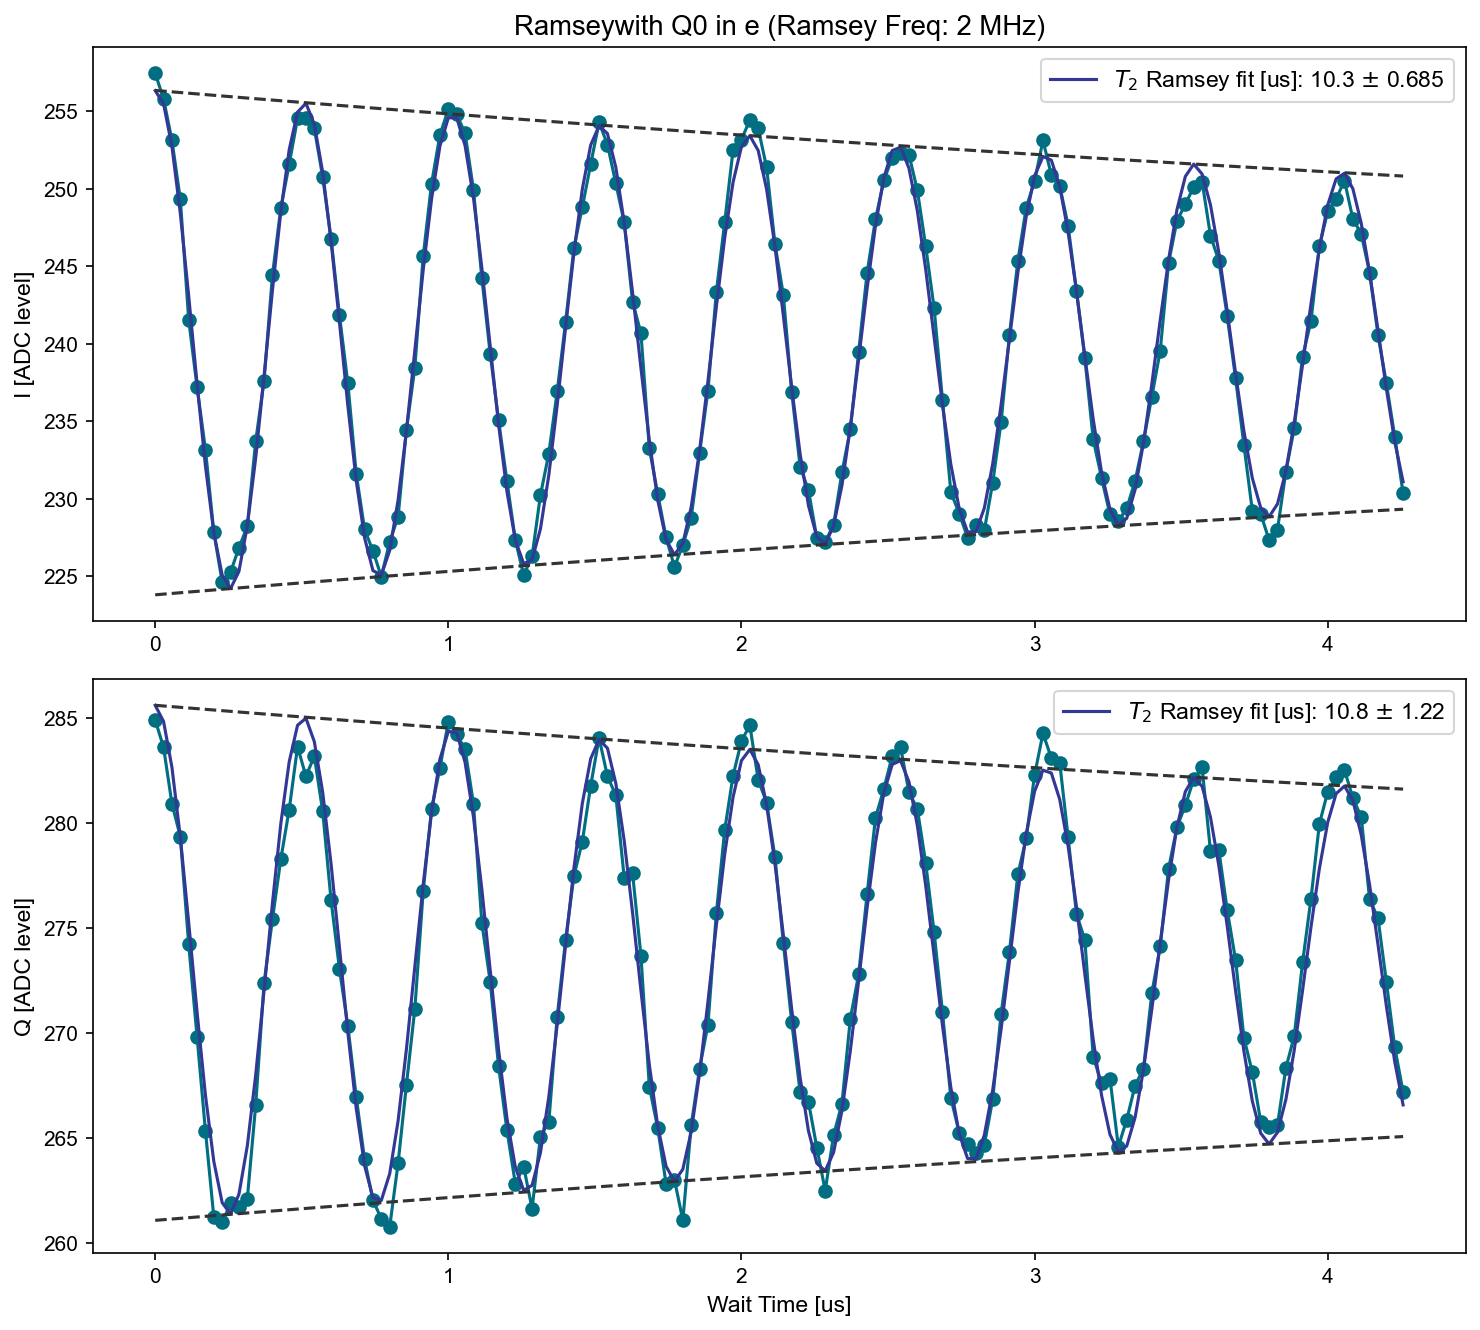

*Set Q1 pi pulse freq with Q0 in e to 3459.687127357855*



######### BEGINNING QUBIT 2 #########
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3463.6825490780166
Fit frequency from I [MHz]: 2.011561819342954 +/- 0.0015260289050623326
Suggested new pi pulse frequency from fit I [MHz]:
 	3463.6709872586734
 	3459.6709872586734
T2 Ramsey from fit I [us]: 10.207798161305183
Fit frequency from Q [MHz]: 2.0112286915468776 +/- 0.001176999162419451
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3463.6713203864697
 	3459.6713203864697
T2 Ramsey from fit Q [us]: 10.516441522436688


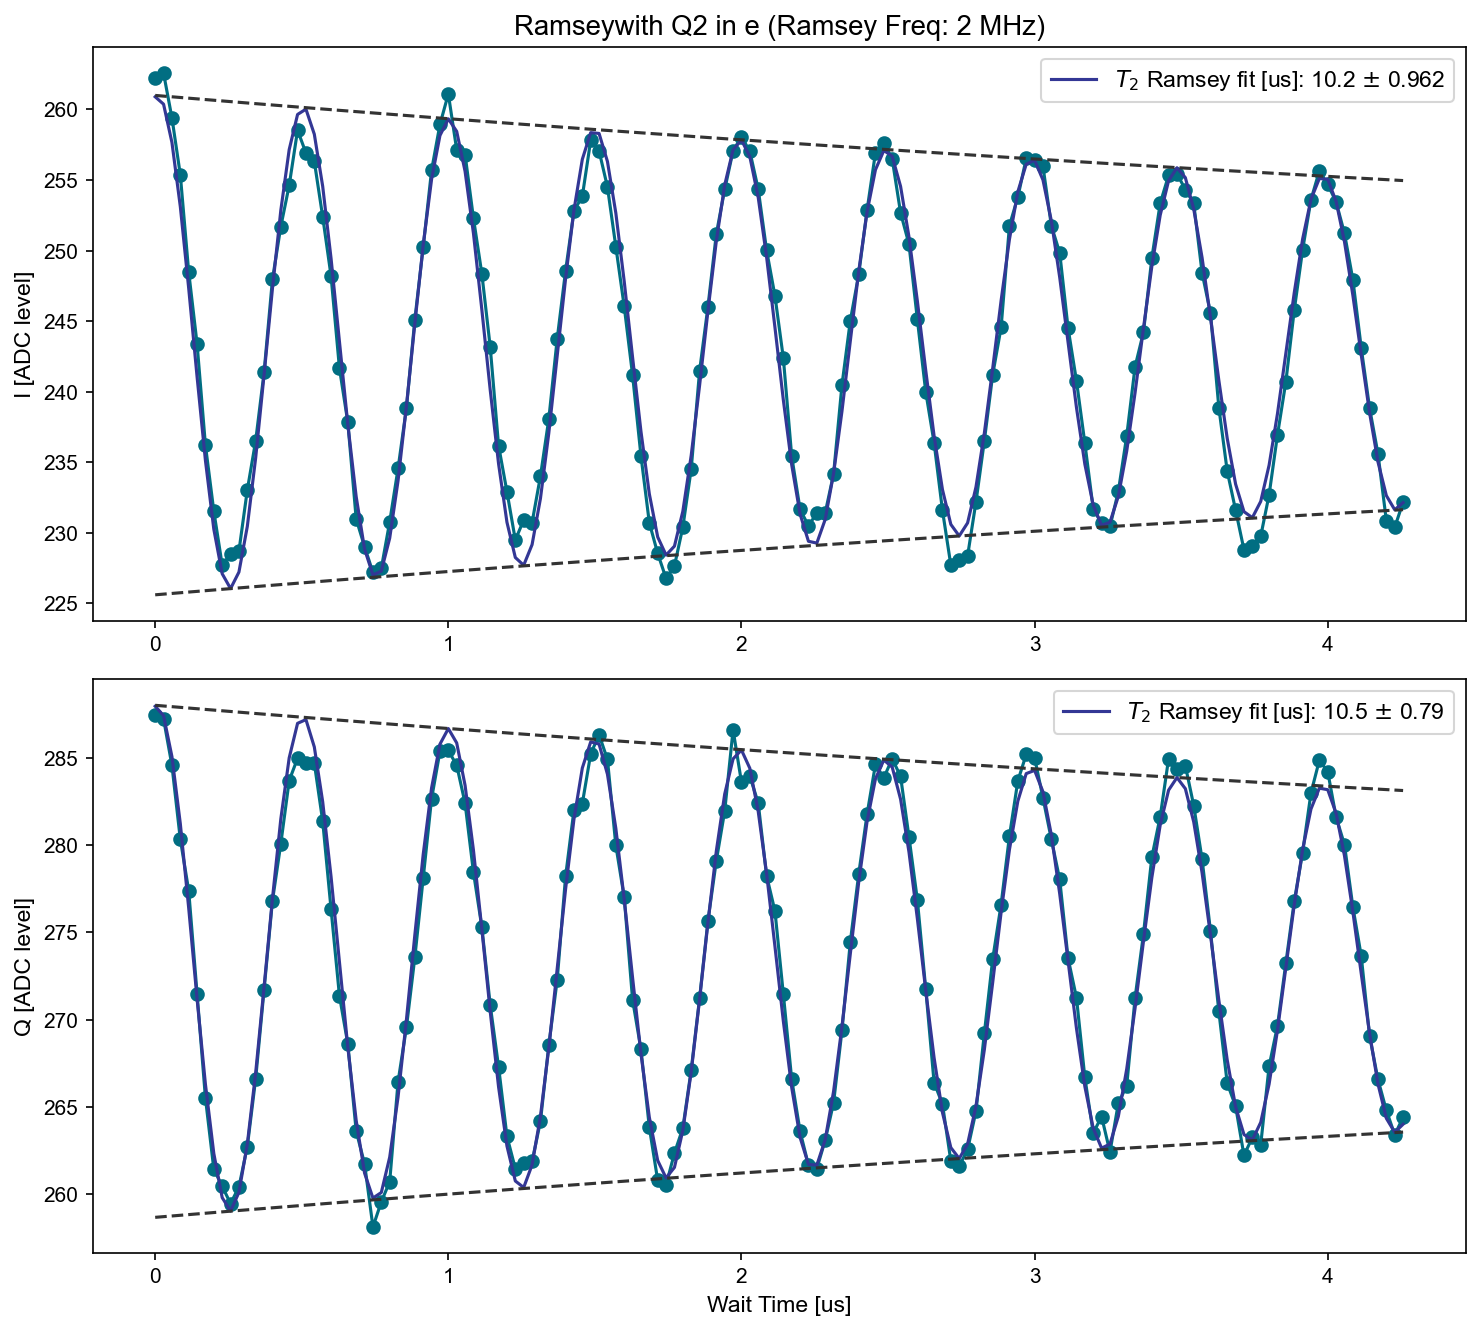

*Set Q1 pi pulse freq with Q2 in e to 3463.6713203864697*



######### BEGINNING QUBIT 3 #########
-------- Ramsey --------


  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3463.5064910321944
Fit frequency from I [MHz]: 2.005964800834961 +/- 0.0017773292195959333
Suggested new pi pulse frequency from fit I [MHz]:
 	3463.5005262313593
 	3459.5005262313593
T2 Ramsey from fit I [us]: 10.678579886040357
Fit frequency from Q [MHz]: 2.003624934816468 +/- 0.0011913705386613004
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3463.502866097378
 	3459.502866097378
T2 Ramsey from fit Q [us]: 12.073747343146913


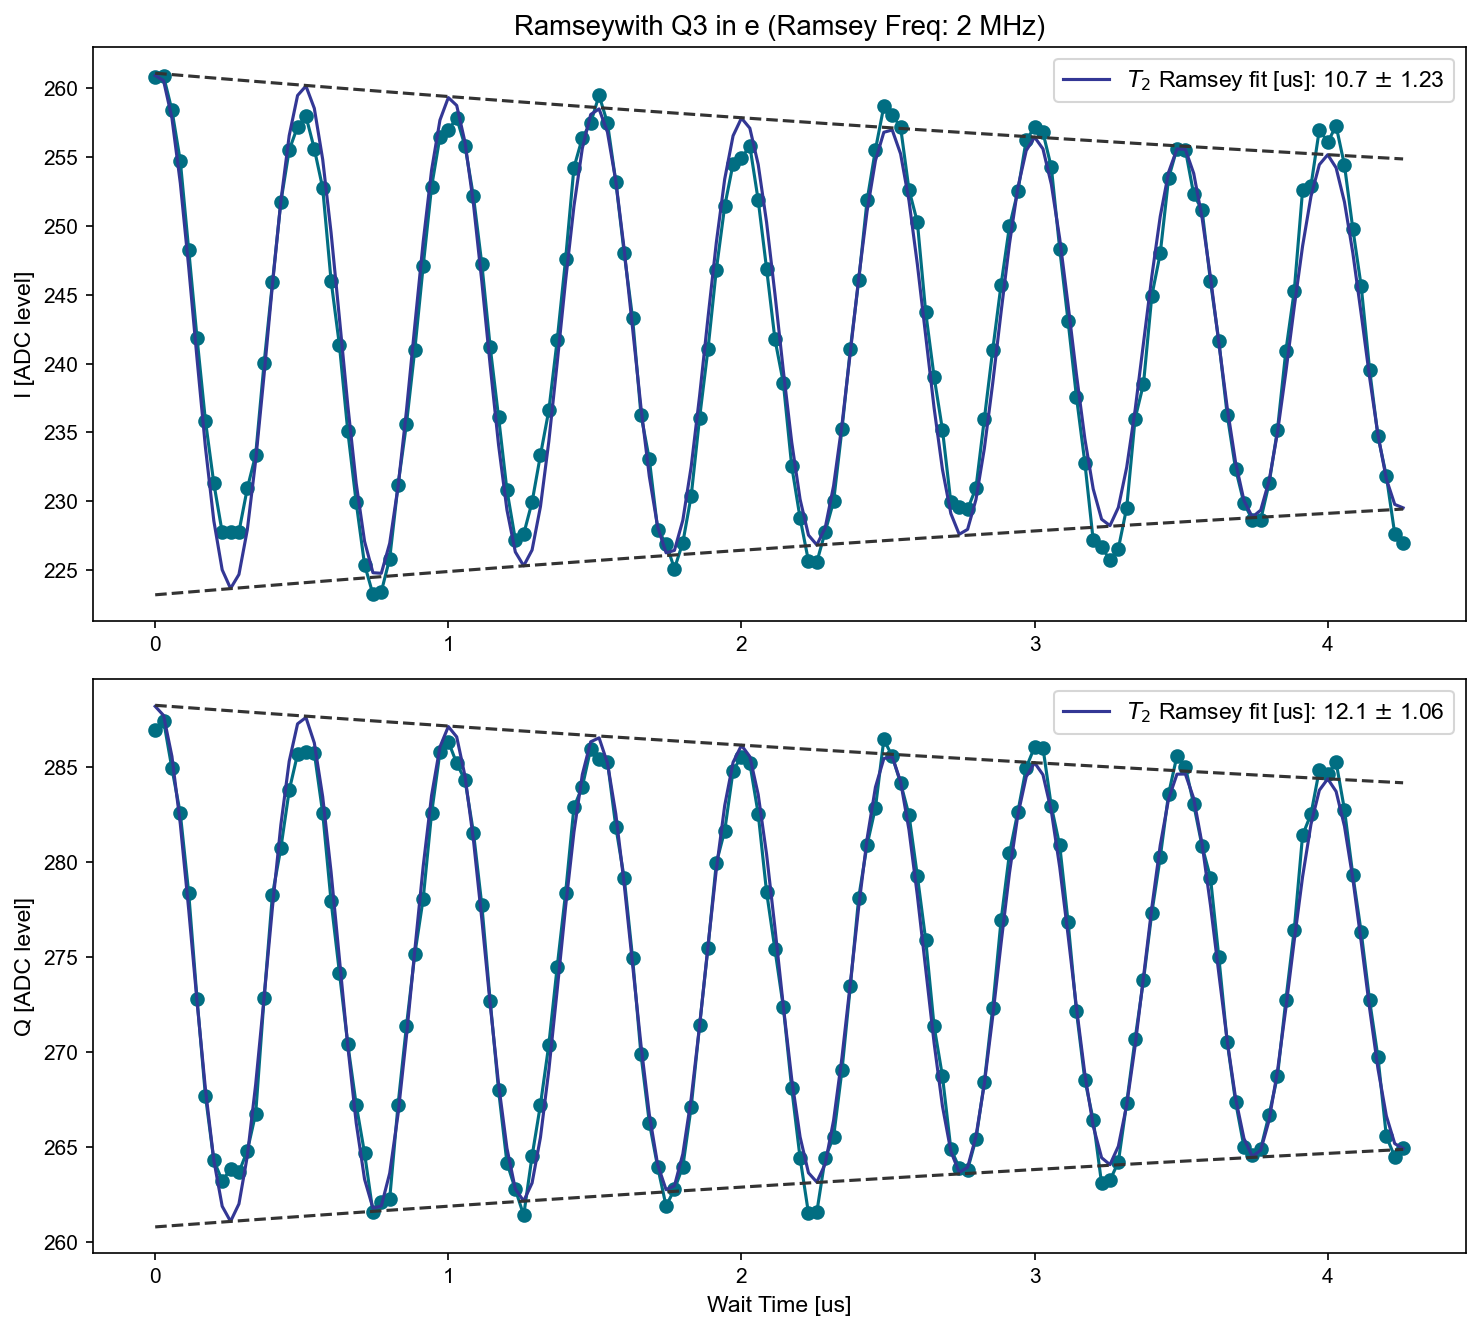

*Set Q1 pi pulse freq with Q3 in e to 3463.502866097378*





In [28]:
q1 = 1
# for q0 in [2]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    # print(f"-------- length rabi --------")
    # lengthrabiZZ = meas.LengthRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    # lengthrabiZZ.cfg.expt = dict(
    #     start=0, # pulse length (sigma) [us]
    #     step=soc.cycles2us(1), # [us]
    #     expts=101,
    #     reps=4000,
    #     gain=20000,
    #     pulse_type='gauss',
    #     qubits=[q0, q1],
    #     checkZZ=True,
    #     checkEF=False, 
    # )

    # try:
    #     import Pyro4.util
    #     try:
    #         lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     lengthrabiZZ.analyze(fit=True)
    
    #     lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    #     lengthrabiZZ.display(fit=True)
    #     p = lengthrabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_len = (3/2 - p[2]/180)/2/p[1]
    #     pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
    #     lengthrabi_decay = p[3]

    #     print(f'Will use sigma {pi_len} for amplitude rabi')

    #     if save_data: saved_files.append(lengthrabiZZ.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue

    # print(f"-------- Amp rabi --------")
    # amprabi = meas.AmplitudeRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"amp_rabi_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    # span = 32000
    # npts = 151

    # amprabi.cfg.expt = dict(
    #     start=0, # qubit gain [dac level]
    #     step=int(span/npts), # [dac level]
    #     expts=npts,
    #     reps=100,
    #     rounds=30,
    #     sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    #     pulse_type='gauss',
    #     checkZZ=True,
    #     checkEF=False, 
    #     qubits=[q0, q1],
    # )
    # try:
    #     import Pyro4.util
    #     try:
    #         amprabi.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     amprabi.analyze(fit=True)

    #     amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    #     p = amprabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    #     if pi_gain > 32000:
    #         amprabi.display(fit=False)
    #         print('WARNING: Fit pi pulse gain is long, please double check!')
    #         pi_gain = 30000
    #     else: amprabi.display(fit=True)
    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
    #     results['sigma'][q0] =  pi_len
    #     print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
    #     results['gain'][q0] =  int(pi_gain)
    #     print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

    #     if save_data: saved_files.append(amprabi.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2, # [MHz]
        reps=100,
        rounds=30,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue
    
    print("\n\n")

In [29]:
print(results)
for saved_file in saved_files:
    print(saved_file)

{'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 0.018190088470661423], 'f_Q1_ZZ': [3459.687127357855, 0, 3463.6713203864697, 3463.502866097378]}
